In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-uci/heart.csv


In [2]:
#additional imports
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.svm  import SVC


In [3]:
path = Path('/kaggle/input/heart-disease-uci/heart.csv')

Loading dataframe and checking what types of data we have

In [4]:
df = pd.read_csv(path)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


looks like everything is numerical , once again we can re-check it with pandas .info() method

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


We also need to find null\NaN values

In [6]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [7]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

We don't need to preprocess text data and fill empty cells. Now we can visualize dataframe to get the idea how features relate to each other.

**Data visualization**

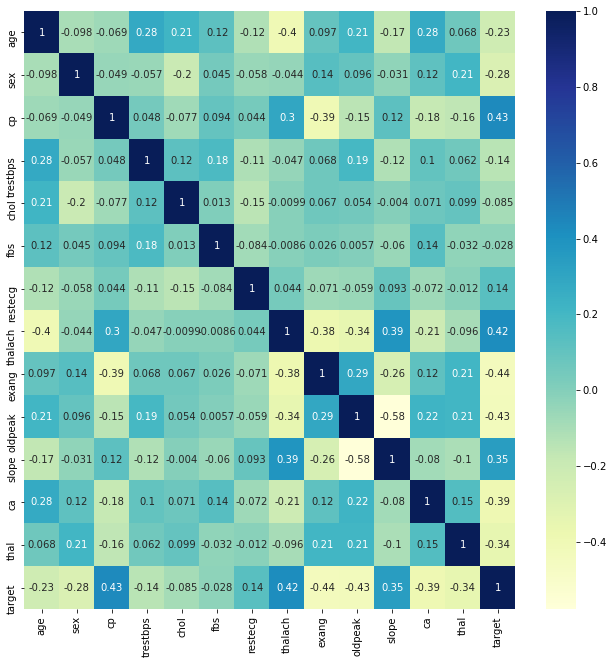

In [8]:
correlation = df.corr()
plt.figure(1,figsize = (11,11))
sns.heatmap(correlation,annot=True,cmap="YlGnBu")

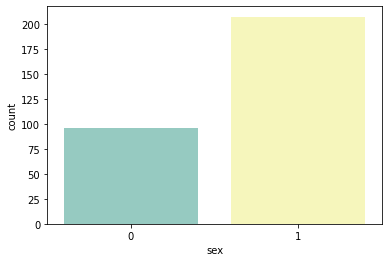

In [9]:
#gender distribution
#1 for a male, and 0 for a female
sns.countplot(x = 'sex', data = df,palette="Set3")

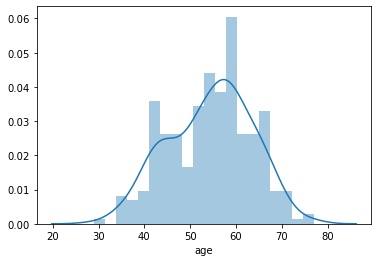

In [10]:
#age distribution
sns.distplot(df['age'] , bins = 20)

rate is spiking after 40 y\o

cp is chest pain rate. and it's highly related to heart desease according to our correlation matrix. let's get plot representation

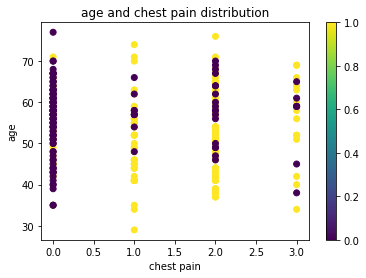

In [11]:
# cp is chest pain rate. 
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(df['cp'],df['age'],c=df.target)
ax.set_title("age and chest pain distribution")
ax.set_xlabel('chest pain')
ax.set_ylabel('age')
plt.colorbar(scatter)

age 40 and older tend to have chest pain without actual heart desease. And it's almost impossible to have a heart desease without pain.

Maximum heart rate (thalach) and ST segment(slope) are highly related to desease.

let's plot

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


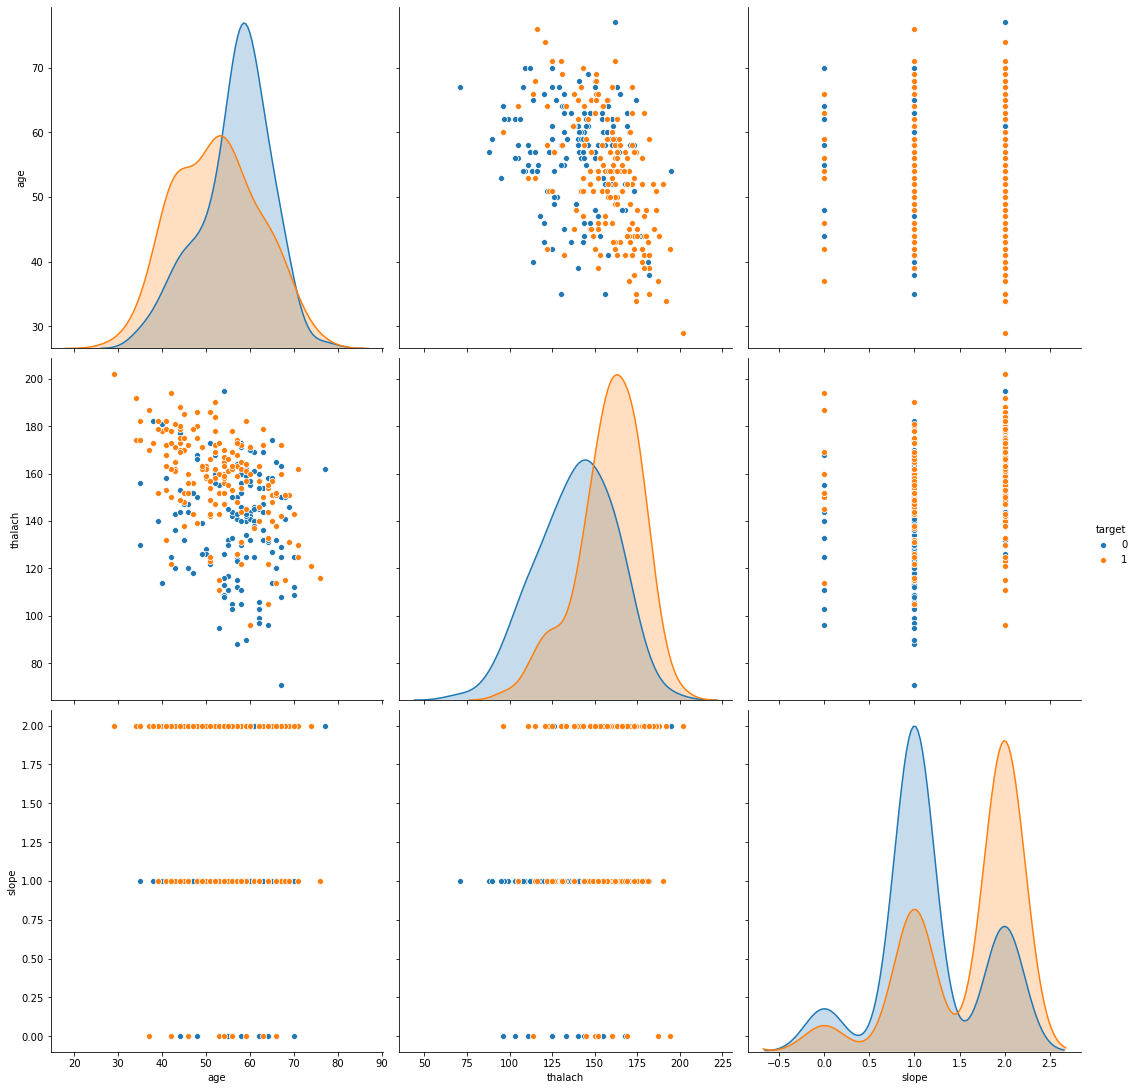

In [12]:
sns.pairplot(df[['age','thalach','slope','target']],hue='target',size=5)

it's tempting to use desicion tree and random forest classifier , but since it's binary classification - most models should have similar performance . I've decided to stick SVC this time

**feature scaling**

In [13]:
scaler = StandardScaler()
df.shape

(303, 14)

In [14]:
X = scaler.fit_transform(df.drop(['target'],axis=1))
y = df.target
X.shape,y.shape

((303, 13), (303,))

train \ test split

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)

We should try Linear SVC first

In [16]:
Lsvcmodel = LinearSVC()
Lsvcmodel.fit(X_train,y_train)
Lsvcmodel.score(X_test,y_test)

0.8360655737704918

before trying other models, i would search for a hyperparameters tuning

In [17]:
params = {'C' : [0.01,0.1,0.25,0.5,0.75,1,10,100],
         'gamma' : [1,0.75,0.5,0.25,0.1,0.01,0.001],
         'kernel': ['rbf','poly','linear']}

In [18]:
gridsearch = GridSearchCV(SVC(),params,refit=True)
gridsearch.fit(X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 0.25, 0.5, 0.75, 1, 10, 100],
                         'gamma': [1, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'linear']})

In [19]:
gridsearch.best_params_

{'C': 0.01, 'gamma': 1, 'kernel': 'linear'}

**creating final model**

In [20]:
Lmodel = SVC(kernel='linear', gamma=1, C=0.01)
Lmodel.fit(X_train,y_train)
Lmodel.score(X_test,y_test)

0.8360655737704918

confusion matrix and classification report

In [21]:
test_pred = Lmodel.predict(X_test)
cm = confusion_matrix(y_test,test_pred)
cm

array([[19,  8],
       [ 2, 32]])

In [22]:
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       0.90      0.70      0.79        27
           1       0.80      0.94      0.86        34

    accuracy                           0.84        61
   macro avg       0.85      0.82      0.83        61
weighted avg       0.85      0.84      0.83        61

